# Importing the Dataset from Kaggle

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle


In [0]:
import json
token = {"username":"ris320","key":"c1b1a638fe03b2b2ef72d10209475644"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized -p /content

In [0]:
!unzip diabetic-retinopathy-resized.zip

In [0]:
!unzip resized_train_cropped.zip



# Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
from google.colab.patches import cv2_imshow
import glob
import math
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers.core import Flatten, Dense, Dropout
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras.optimizers import SGD, Adam, Adamax,rmsprop
# from keras.layers import Dense, GlobalAveragePooling2D
#import tensorflow as tf
#from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#from sklearn.utils import class_weight
#from sklearn.preprocessing import OneHotEncoder
#from catboost import CatBoostClassifier
#import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
# from keras.models import Sequential
# from keras.layers.core import Flatten, Dense, Dropout
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras.optimizers import SGD, Adam, Adamax,rmsprop
# from keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.python.keras.utils.data_utils import Sequence
from imblearn.over_sampling import SMOTE
from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import  RandomUnderSampler
# import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import  RandomOverSampler
# import pickle

In [0]:
 #!pip install catboost

# Importing the dataset

In [0]:
dataset=pd.read_csv('trainLabels_cropped.csv')


# Exploratory Data Analysis

In [0]:
print(dataset.head(10))



   Unnamed: 0  Unnamed: 0.1     image  level
0           0             0   10_left      0
1           1             1  10_right      0
2           2             2   13_left      0
3           3             3  13_right      0
4           4             4   15_left      1
5           5             5  15_right      2
6           6             6   16_left      4
7           7             7  16_right      4
8           8             8   17_left      0
9           9             9  17_right      1


In [0]:
dataset.drop(columns={'Unnamed: 0','Unnamed: 0.1'},axis=1,inplace=True)


In [0]:
print(dataset.head(10))

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
5  15_right      2
6   16_left      4
7  16_right      4
8   17_left      0
9  17_right      1


In [0]:
print(dataset.isnull().sum()/len(dataset))

image    0.0
level    0.0
dtype: float64


In [0]:
print(dataset.dtypes)

image    object
level     int64
dtype: object


In [0]:
print(len(dataset))

35108


Text(0, 0.5, 'count')

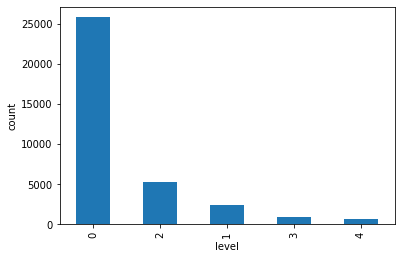

In [0]:
dataset['level'].value_counts().plot(kind='bar')
plt.xlabel('level')
plt.ylabel('count')




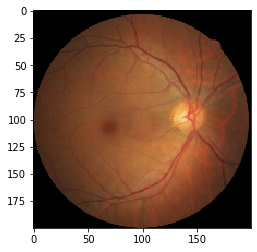

In [0]:
#Plotting the Image
img=cv2.imread('resized_train_cropped/resized_train_cropped/1040_right.jpeg')
img=cv2.resize(img,(200,200))
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#cv2_imshow(img)
plt.imshow(image)


In [0]:
# temp = []
# for img_name in dataset.image+str('.jpeg'):
#     img_path = os.path.join(os.getcwd(), 'resized_train_cropped', img_name)
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (112,112))
#     img = img.astype('float32') # this will help us in later stage
#     temp.append(img)
    

# train = np.stack(temp)

# Feature Extraction using Pretrained VGG16

In [0]:

model = VGG16(weights='imagenet', include_top=False)
model.summary()
vgg16_feature_list = []

for img_name in dataset.image+str('.jpeg'):
    img_path=os.path.join(os.getcwd(),'resized_train_cropped/resized_train_cropped',img_name)  
    img = image.load_img(img_path, target_size=(200, 200))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())

train = np.array(vgg16_feature_list)




Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
print(len(train))



35108


In [0]:
 #train=train.astype('float32')

In [0]:
# Normalizing the Images

#train=train/255.

In [0]:
train_y=dataset.loc[:,'level']



In [0]:
train_y

0        0
1        0
2        0
3        0
4        1
        ..
35103    0
35104    0
35105    0
35106    0
35107    1
Name: level, Length: 35108, dtype: int64

In [0]:
train_y=train_y.astype('category')

In [0]:
# print(train_y.head(10))

print(train_y)

0        0
1        0
2        0
3        0
4        1
        ..
35103    0
35104    0
35105    0
35106    0
35107    1
Name: level, Length: 35108, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]


# One Hot Encoding

In [0]:
 train_y=pd.get_dummies(train_y)

In [0]:
 print(train_y.head(10))

level  0  1  2  3  4
0      1  0  0  0  0
1      1  0  0  0  0
2      1  0  0  0  0
3      1  0  0  0  0
4      0  1  0  0  0
5      0  0  1  0  0
6      0  0  0  0  1
7      0  0  0  0  1
8      1  0  0  0  0
9      0  1  0  0  0


In [0]:
len(train)

35108

# Splitting into Train, Test and Validation

In [0]:

train_x,test_x,train_y,test_y=train_test_split(train,train_y,test_size=0.30)


In [0]:
# print(len(train_x))

# test_x,val_x,test_y,val_y=train_test_split(test_x,test_y,test_size=0.30)

# !pip install imblearn

In [0]:
len(train_y)


24575

In [0]:
train_x.shape

(24575, 18432)

# Training the Model

In [0]:
# model = tf.keras.Sequential()

# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(112,112,3)))
# model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.2))
 
# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dropout(0.2))
 
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.Dropout(0.2))

# model.add(tf.keras.layers.Dense(5, activation='softmax'))


# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [0]:
# history=model.fit(train_x,train_y,
#            batch_size=64,
#            shuffle=False,
#            epochs=10,
#            validation_split=0.30)


In [0]:
train_y

level,0,1,2,3,4
4672,0,0,1,0,0
21846,0,0,1,0,0
26625,1,0,0,0,0
10304,1,0,0,0,0
17862,0,0,1,0,0
...,...,...,...,...,...
33236,1,0,0,0,0
24533,1,0,0,0,0
18815,1,0,0,0,0
26528,1,0,0,0,0


# Training and Validation Accuracy

In [0]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Training and Validation Loss

In [0]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Handling Imbalanced Classes

In [0]:
#SMOTE

# from imblearn.over_sampling import SMOTE

# smote=SMOTE('minority')

# train_x,train_y_1=smote.fit_sample(train_x,train_y)

# print(train_x.shape,train_y.shape)


# #  Random UnderSampling

# rus=RandomUnderSampler('majority',random_state=42)

# X_res,y_res=rus.fit_resample(train_x,train_y.iloc[:,0])


#Random OverSampling

ros=RandomOverSampler('minority',random_state=42)

X_res,y_res= ros.fit_resample(train_x,train_y.iloc[:,1])


Text(0, 0.5, 'count')

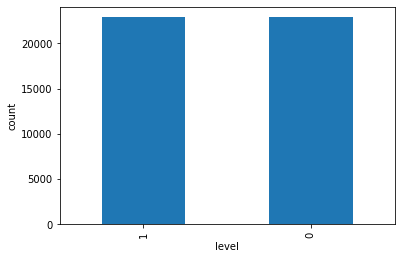

In [0]:
y_res=pd.Series(y_res)
y_res.value_counts().plot(kind='bar')
plt.xlabel('level')
plt.ylabel('count')

# Fitting Classifier to the Training Data

In [0]:
# class_weights=dict({0:1.5,1:12,2:11,3:30,4:40})

# Level 0-parameters n_estimators=300,max_depth=6


classifier=RandomForestClassifier(n_estimators=300,max_depth=6)

# classifier=BalancedRandomForestClassifier(n_estimators=200,max_depth=7)

classifier.fit(X_res,y_res)



# classifier=CatBoostClassifier(iterations=18,depth=6,task_type='GPU'
#                               ,boosting_type='Plain',max_ctr_complexity=1,gpu_ram_part=0.7,
#                               gpu_cat_features_storage='CpuPinnedMemory')

# classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)


# classifier.fit(X_res,y_res)



# classifier.fit(train_x,train_y.iloc[:,0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#Hyperparameter Tuning

#Randomized Search CV

param_list={'n_estimators':[100,200,300],
             'max_depth':[1,2,3,4]}
n_iter_search = 10

random_search = RandomizedSearchCV(classifier, param_distributions=param_list,
                                   n_iter=n_iter_search)

random_search.fit(X_res,y_res)

print(random_search.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
# # Predicting the train set results
y_pred_train=classifier.predict(X_res)

# Predicting the Test set results
y_pred_test=classifier.predict(test_x)


In [0]:
#Checking the Accuracy

print("Training Accuracy is:",accuracy_score(y_pred_train,y_res))

print("Testing Accuracy is:",accuracy_score(y_pred_test,test_y.iloc[:,1]))


Training Accuracy is: 0.8082742937111869
Testing Accuracy is: 0.6688502800721542


In [0]:
# Confusion Matrix for training data

cm=confusion_matrix(y_target=y_res,y_predicted=y_pred_train)


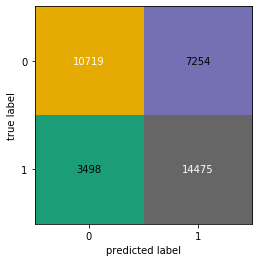

In [0]:
fig,ax=plot_confusion_matrix(conf_mat=cm,cmap='Dark2')

plt.show()

In [0]:
# # Confusion Matrix for test data
cm=confusion_matrix(y_target=test_y.iloc[:,0],y_predicted=y_pred_test)



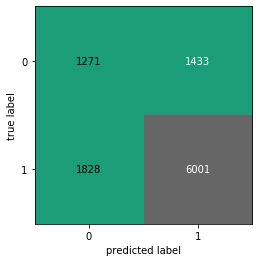

In [0]:
fig,ax=plot_confusion_matrix(conf_mat=cm,cmap='Dark2')
plt.show()

In [0]:
# Classification Report

print("Training Classification Report",classification_report(y_res,y_pred_train))


print("Testing Classification Report",classification_report(test_y.iloc[:,0],y_pred_test))



Training Classification Report               precision    recall  f1-score   support

           0       0.75      0.60      0.67     17973
           1       0.67      0.81      0.73     17973

    accuracy                           0.70     35946
   macro avg       0.71      0.70      0.70     35946
weighted avg       0.71      0.70      0.70     35946

Testing Classification Report               precision    recall  f1-score   support

           0       0.41      0.47      0.44      2704
           1       0.81      0.77      0.79      7829

    accuracy                           0.69     10533
   macro avg       0.61      0.62      0.61     10533
weighted avg       0.71      0.69      0.70     10533

